In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import seaborn as sns
import json
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [27]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"

#Source NL https://pageviews.wmcloud.org/?project=nl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Bezorgdheid|Eenzaamheid|Slapeloosheid|Depressie_(klinisch)
#Source IT https://pageviews.wmcloud.org/?project=it.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Ansia|Disturbo_depressivo|Insonnia|Solitudine
#Source PL https://pageviews.wmcloud.org/?project=pl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=L%C4%99k|Zaburzenia_depresyjne|Bezsenno%C5%9B%C4%87%7CSamotno%C5%9B%C4%87%7CStres
#Source SV https://pageviews.wmcloud.org/?project=sv.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Ångest|Depression|Sömnlöshet|Ensamhet|Stress

NL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_nl_2019.csv"
IT_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_it_2019.csv"
PL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_pl_2019.csv"
SV_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_sv_2019.csv"


In [159]:
EFFECT_DURATION = 10
LANGUAGES = ['nl', 'sv', 'pl', 'it']
region = {
    'nl':'Netherlands',
    'sv':'Sweden',
    'pl':'Poland',
    'it':'Italy'
}
diseases_names = {
    'en':['anxiety', 'depression', 'insomnia', 'loneliness', 'stress'],
    'nl':['Bezorgdheid', 'Depressie (klinisch)', 'Slapeloosheid', 'Eenzaamheid', 'Stress'],
    'it':['Ansia', 'Disturbo depressivo', 'Insonnia', 'Solitudine', 'Stress'],
    'sv':['Ångest', 'Depression', 'Sömnlöshet', 'Ensamhet', 'Stress'],
    'pl':['Lęk', 'Zaburzenia depresyjne', 'Bezsenność', 'Samotność', 'Stres']
}

LANG_TEXTS = {'nl': 'Dutch', 'sv': 'Swedish', 'pl': 'Polish', 'it': 'Italian'}

In [160]:
interventions_data = pd.read_csv(INTERVENTIONS_DATASET)
apple_mobility_data = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
google_mobility_data = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)

pageviews_data = {}
pageviews_data['nl'] = pd.read_csv(NL_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['it'] = pd.read_csv(IT_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['sv'] = pd.read_csv(SV_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['pl'] = pd.read_csv(PL_PAGEVIEWS_DATASET, low_memory=False)

In [161]:
interventions_data.set_index('lang', inplace=True)

In [162]:
#augment data with interventions date in poland
interventions_data.loc['pl'] = [np.nan, '2020-03-12', '2020-03-12', np.nan,'2020-03-12', np.nan, np.nan]
interventions_data

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15


In [163]:
for col in interventions_data.columns:
    interventions_data[col] = pd.to_datetime(interventions_data[col])

In [164]:
def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang] 
    if start is pd.NaT:
        start = interventions_data['Mobility'].loc[lang] 
    end = interventions_data['Normalcy'].loc[lang]
    if start is pd.NaT or end is pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

In [165]:
def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['Month'] = df['Date'].apply(lambda x: x.strftime('%m/%Y')) #add month
    df['Year'] = df['Date'].apply(lambda x: str(x.strftime('%Y')))
    # interquartile range approach for deleting outliers
    for diseas in diseases_names['en']:
        Q1 = df[diseas].quantile(0.25)
        Q3 = df[diseas].quantile(0.75)
        IQR = Q3 - Q1    

        df[diseas] = np.clip(np.array(df[diseas]), Q1 - 1.5 * IQR, Q3 + 1.5 *IQR)  

    # df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Date', 'Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'Month', 'Year']]
    return df

In [166]:
LANGUAGES = ['nl', 'sv', 'pl', 'it']
#each array with have 5 elements, one for each disease
#the order of the diseases will be :  'anxiety', 'depression', 'insomnia', 'loneliness', 'stress'

In [167]:
for lang in LANGUAGES:
    pageviews_data[lang] = get_pageviews_data(lang)

In [168]:
pageviews_data['it']

,anxiety,depression,insomnia,loneliness,stress,Date,Day_of_the_week,first_case,first_death,lockdown,Month,Year
0,283.0,466.0,162.0,109.0,51.0,2019-01-01,Tuesday,0,0,0,01/2019,2019
1,344.0,547.0,202.0,100.0,94.0,2019-01-02,Wednesday,0,0,0,01/2019,2019
2,319.0,547.0,242.0,68.0,87.0,2019-01-03,Thursday,0,0,0,01/2019,2019
3,349.0,523.0,218.0,77.0,96.0,2019-01-04,Friday,0,0,0,01/2019,2019
4,337.0,489.0,172.0,81.0,99.0,2019-01-05,Saturday,0,0,0,01/2019,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
604,211.0,481.0,131.0,46.0,91.0,2020-08-27,Thursday,0,0,0,08/2020,2020
605,215.0,455.0,160.0,43.0,109.0,2020-08-28,Friday,0,0,0,08/2020,2020
606,215.0,507.0,194.0,47.0,90.0,2020-08-29,Saturday,0,0,0,08/2020,2020
607,242.0,536.0,219.0,49.0,112.0,2020-08-30,Sunday,0,0,0,08/2020,2020


In [172]:
from datetime import datetime

# A function for plotting boxplots of page views by month for a given language, disease and period [start_date, end_date]

def plot_monthly_stats(lang, page_name, start_date, end_date, show_outliers=True):
    df = pageviews_data[lang].copy()
    sns.set(rc={'figure.figsize':(12,8)})
    plt.title('Monthly boxplots of page views for Disease: {} and Language: {} from {} to {}'.format(page_name,
                                                                                                    LANG_TEXTS[lang], start_date, end_date))
    
    #consider only data in period [start_date, end_date]
    data = df[(df['Date'].dt.date >= datetime.strptime(start_date, '%Y-%m-%d').date())  &  
              (df['Date'].dt.date <= datetime.strptime(end_date, '%Y-%m-%d').date())]

    # plot boxplot    
    ax = sns.boxplot(x='Month', y=page_name, data=data,
                        showmeans=True, showfliers=show_outliers)
    # plot average of pageviews by month 
    ax = sns.pointplot(x='Month', y=page_name, data=data,
                       errorbar=None, color='black')

    ax.tick_params(axis='x', labelrotation=90)
    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('PageViews')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


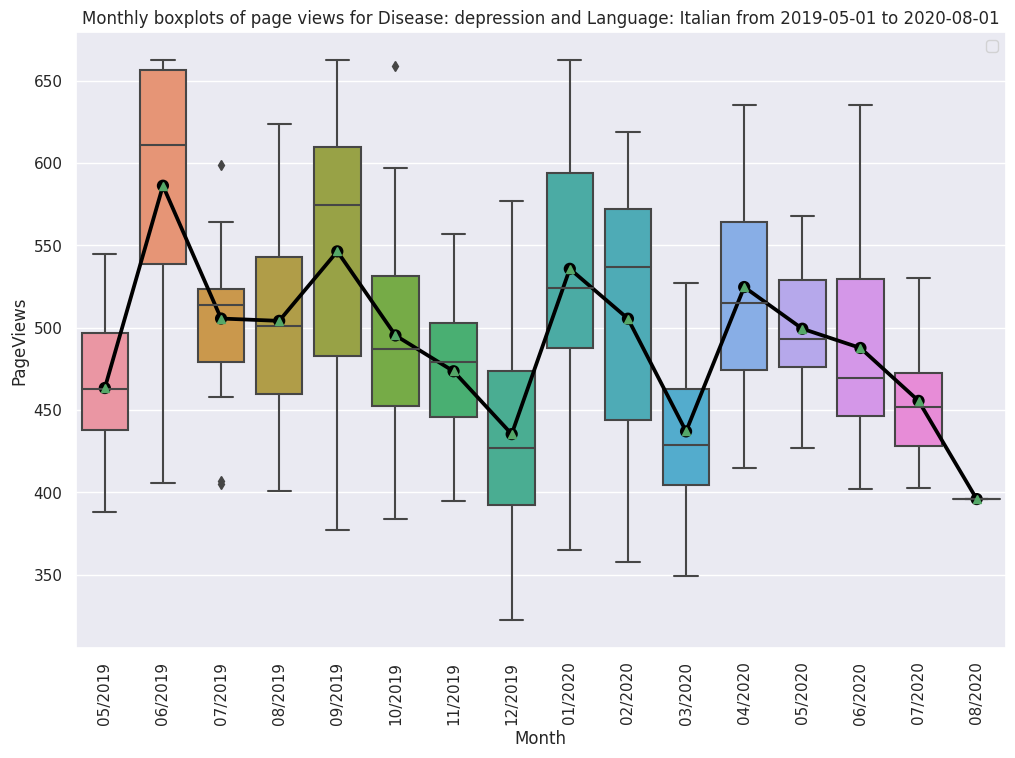

In [ ]:
plot_monthly_stats('it', 'depression', '2019-05-01', '2020-08-01')

In [174]:
#A function for plotting the average number of pageviews by month for all disorders and for a given period
# [start_date, end_date]



def plot_compare_disorders(lang, start_date, end_date, errorbar='sd'):
    # consider data for the given language
    df = pageviews_data[lang].copy()
    # consider only data in period [start_date, end_date]
    data = df[(df['Date'].dt.date >= datetime.strptime(start_date, '%Y-%m-%d').date())  &  
              (df['Date'].dt.date <= datetime.strptime(end_date, '%Y-%m-%d').date())]
    
    fig, ax = plt.subplots(figsize=(14, 9))
    plt.title('Monthly average number of pageviews for each disorders from {} to {} in {}'.format(start_date, end_date, region[lang]))
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    # plot horizontal lines for the dates of '1st case', lockdown and Normalcy dates.
    for diseases in diseases_names['en']:
        sns.lineplot(data = data, x = "Date", y = diseases, label = diseases, errorbar=errorbar)
    try:
        plt.axvline(interventions_data.loc[lang]['1st case'], color = 'red', label = 'First case of Covid')
    except:
        pass
    try:
        plt.axvline(interventions_data.loc[lang]['Lockdown'], color = 'black', label = 'Lockdown')
    except:
        plt.axvline(interventions_data.loc[lang]['Mobility'], color = 'black', label = 'Lockdown')
    try:
        plt.axvline(interventions_data.loc[lang]['Normalcy'], color = 'green', label = 'Normalcy')
    except:
        pass
    # Put the date on the x axis vertically 
    ax.tick_params(axis='x', labelrotation=90)
    plt.xlabel('Month')
    plt.ylabel('PageViews')
    plt.legend()
    plt.show()

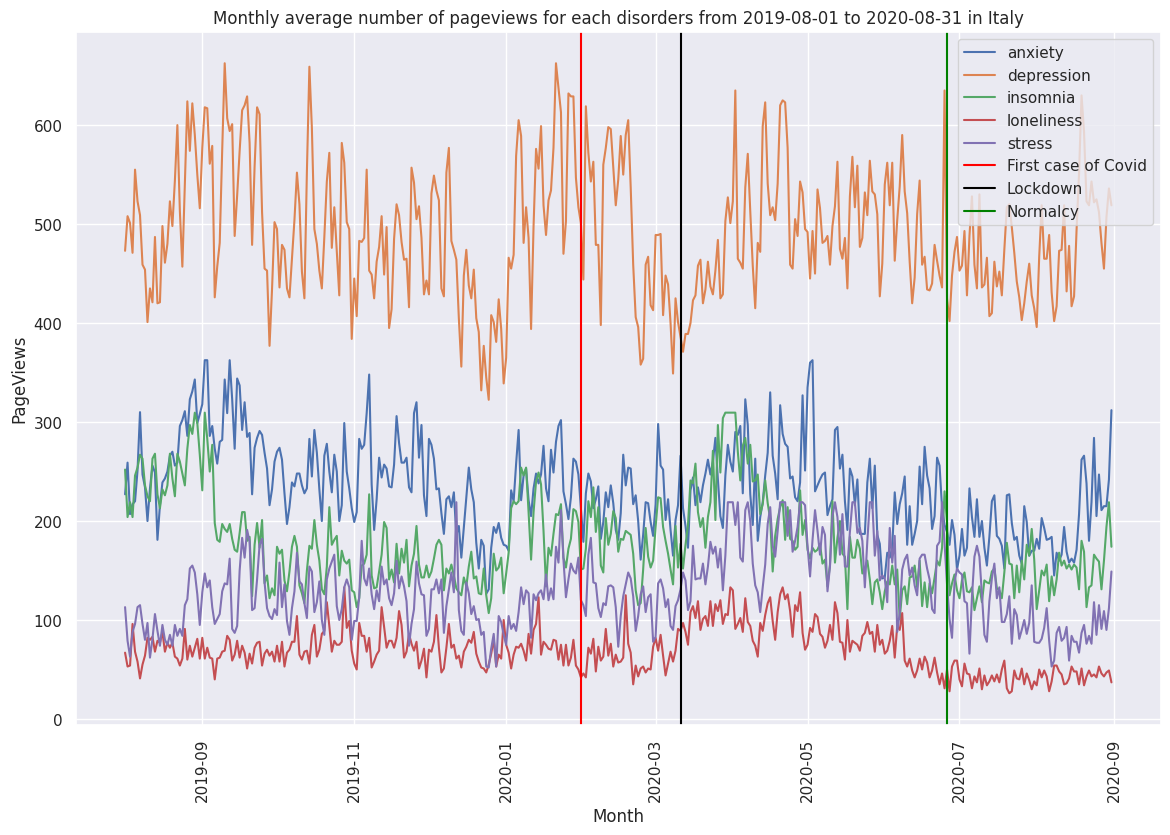

In [175]:
plot_compare_disorders('it', '2019-08-01', '2020-08-31')

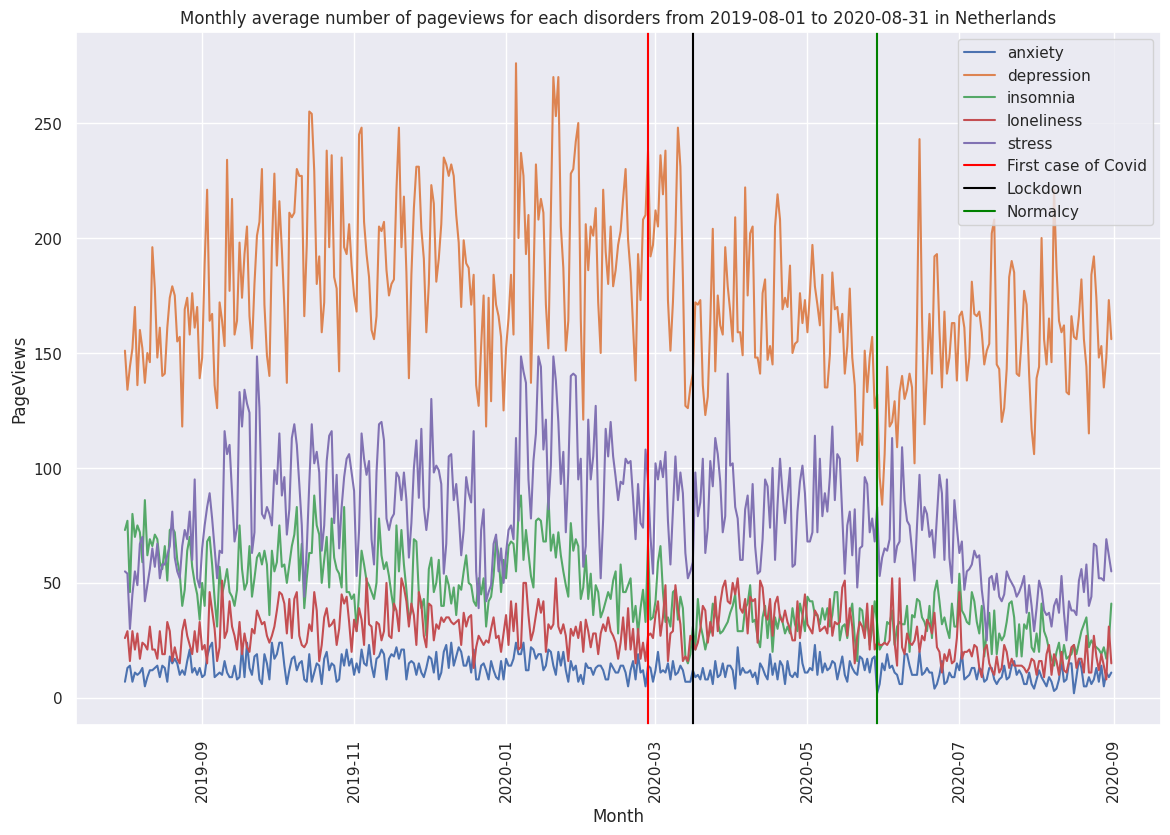

In [93]:
plot_compare_disorders('nl', '2019-08-01', '2020-08-31')

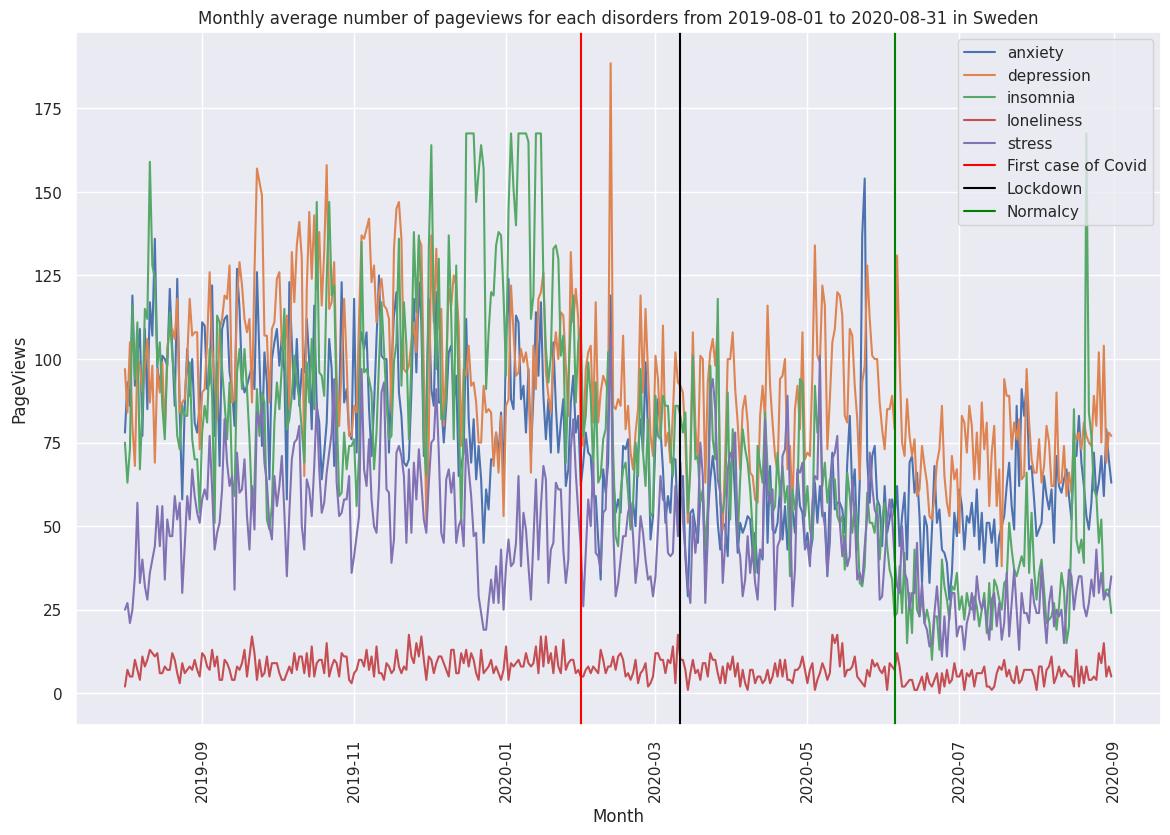

In [94]:
plot_compare_disorders('sv', '2019-08-01', '2020-08-31')

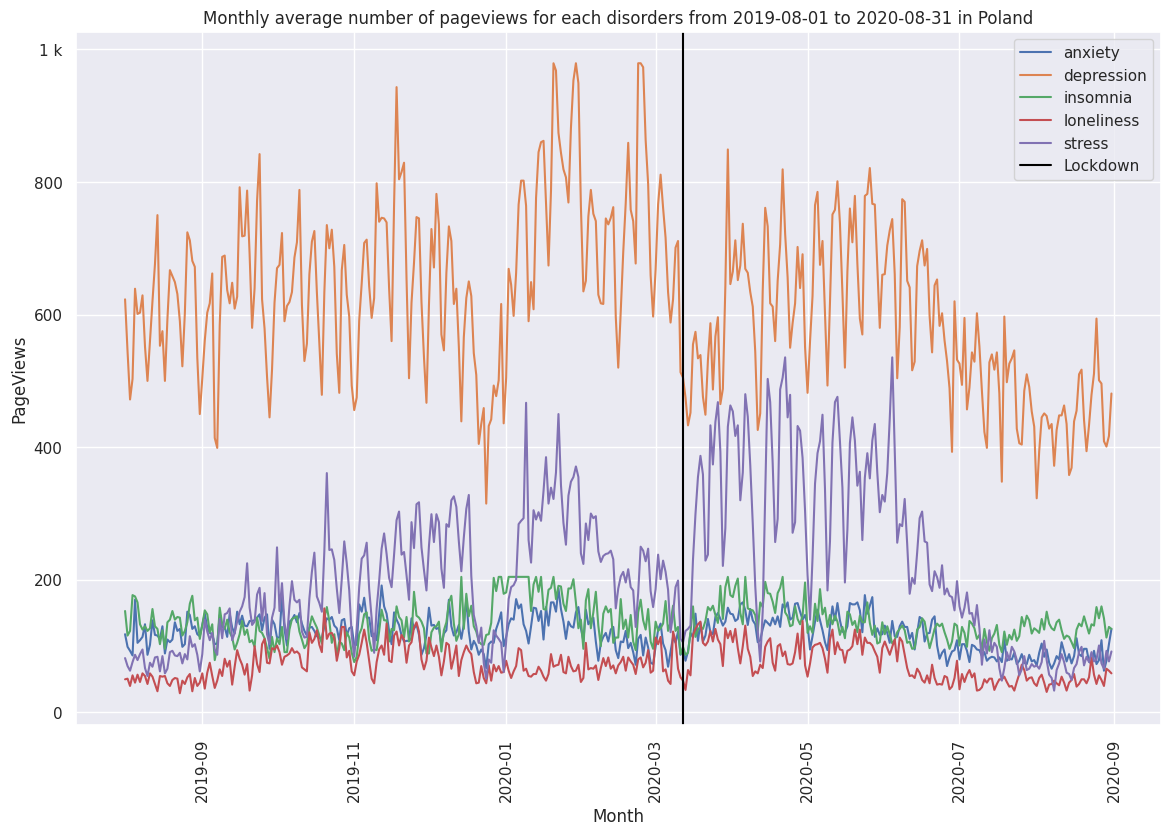

In [95]:
plot_compare_disorders('pl', '2019-08-01', '2020-08-31')

# Distance from normality

We introduce a notion of “distance from normality” as follows. On each day, the pageviews in a given language edition form a distribution over mental health articles, characterizing how users’ attention was distributed. We represent each daily distribution as an “attention vector” of dimension 5 with one entry per article and entries summing to 1.

The notion of “normal” attention is captured by the average attention vector over all days of 2019, i.e., well before the pandemic; and for each subsequent day, the distance from normality is given by the Euclidean distance of that day’s attention vector from the average attention vector. Notice that we calculated the attention vector separately for each language edition.

We use this metric to understand overall changes in the information seeking patterns of Wikipedia users on mental health articles.

In [176]:
# Let's for each language find "normal” attention vector and for each day calculate the distance from normality.
for lang in LANGUAGES:
    # data for the given language
    pageviews = pageviews_data[lang].copy()
    
    # data for the given language in 2019
    pageviews_2019 = pageviews[pageviews['Date'].dt.date < datetime.strptime('2020-01-01', '%Y-%m-%d').date()]
    
    # Normalize pageviews for 2019
    pageviews_attention_vector_2019 = np.array(pageviews_2019[diseases_names['en']])
    pageviews_attention_vector_2019 /= pageviews_attention_vector_2019.sum(axis=1).reshape(-1, 1)
    
    # Find “normal” attention vector by averaging attention vectors over all days of 2019
    normal_attention_vector = np.mean(pageviews_attention_vector_2019, axis=0)
    
    # Normalize pageviews for whole period
    pageviews_attention_vector = np.array(pageviews[diseases_names['en']])
    pageviews_attention_vector /= pageviews_attention_vector.sum(axis=1).reshape(-1, 1)
    
    #For each day calculate the distance from normality.
    pageviews_data[lang]['Distance_from_Normality'] = np.sqrt(np.sum((pageviews_attention_vector - normal_attention_vector) ** 2, axis=1))

In [112]:
def plotDistanceFromNormality(lang):
    # data for the given language
    df = pageviews_data[lang].copy()
    
    # plot distance from normality
    fig, ax = plt.subplots(figsize=(14, 9))
    plt.title('Distance from Normality For {} Mental Health Pages'.format(region[lang]))
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    # plot horizontal lines for the dates of '1st case', lockdown and Normalcy dates.
    plt.plot(df['Date'],df['Distance_from_Normality'], label = 'Distance from Normality')
    try:
        plt.axvline(interventions_data.loc[lang]['1st case'], color = 'red', label = 'First case of Covid')
    except:
        pass
    try:
        plt.axvline(interventions_data.loc[lang]['Lockdown'], color = 'black', label = 'Lockdown')
    except:
        plt.axvline(interventions_data.loc[lang]['Mobility'], color = 'black', label = 'Lockdown')
    try:
        plt.axvline(interventions_data.loc[lang]['Normalcy'], color = 'green', label = 'Normalcy')
    except:
        pass
    
    ax.tick_params(axis='x', labelrotation=90)
    plt.xlabel('Date')
    plt.ylabel('Distance from Normality')
    plt.legend()
    plt.show()

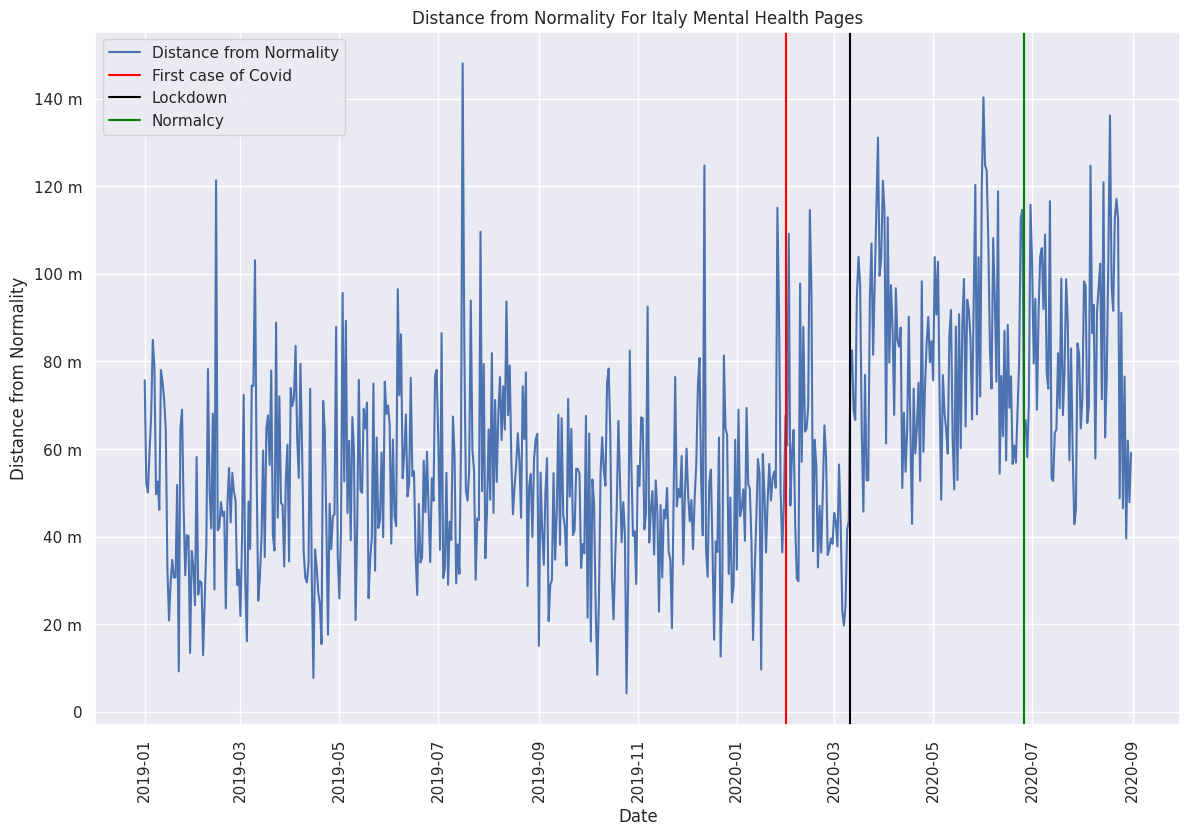

In [113]:
plotDistanceFromNormality('it')

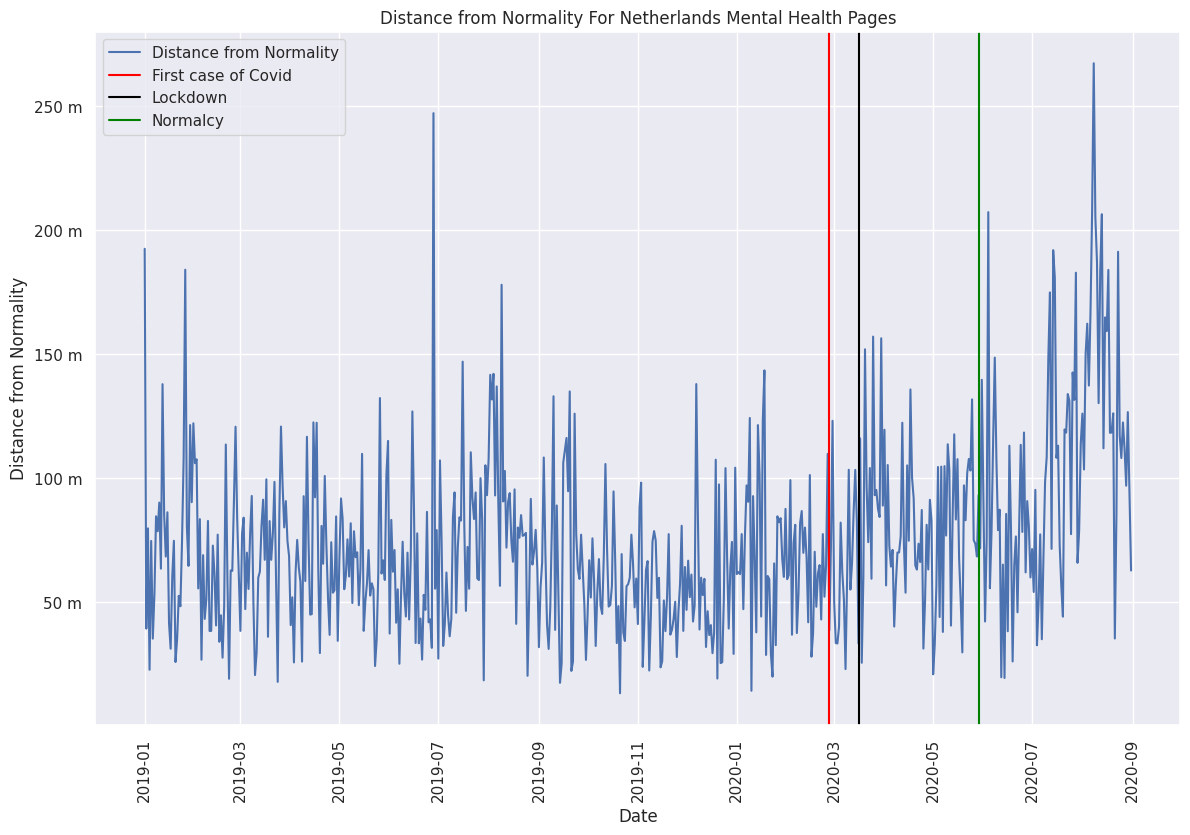

In [114]:
plotDistanceFromNormality('nl')

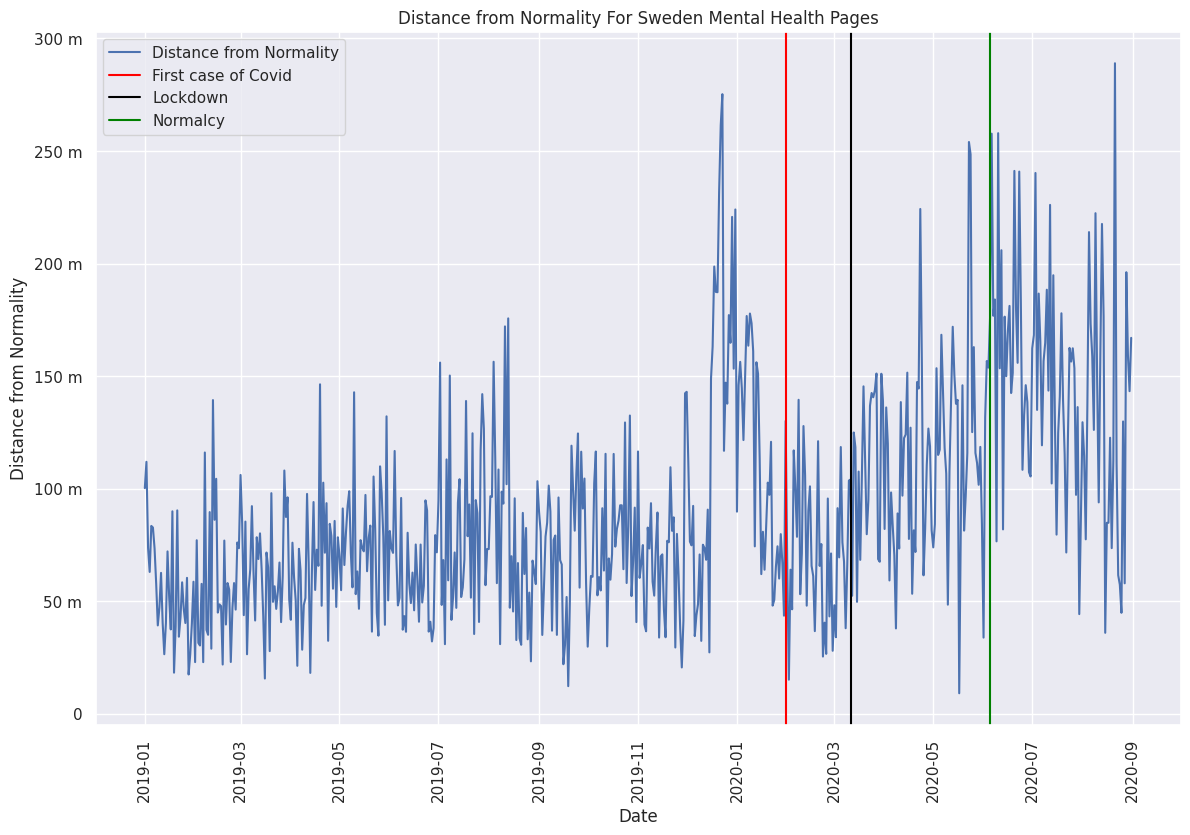

In [115]:
plotDistanceFromNormality('sv')

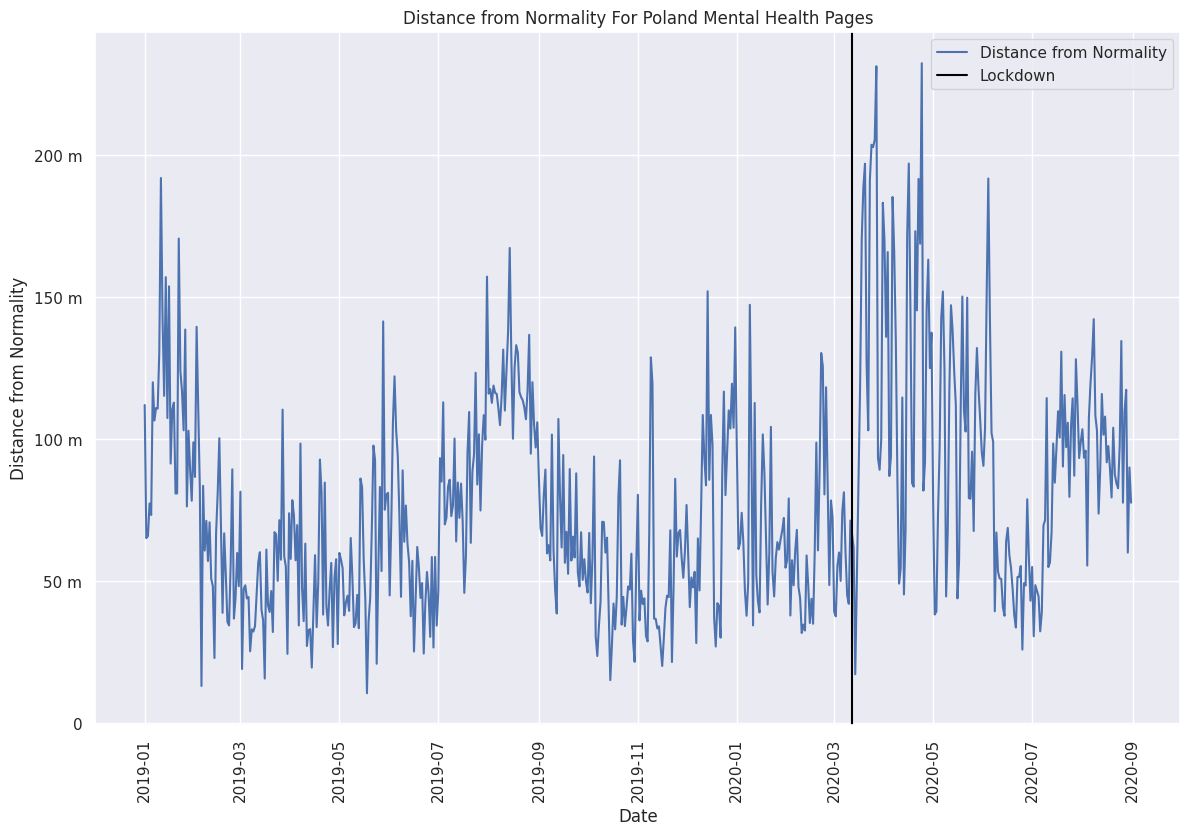

In [116]:
plotDistanceFromNormality('pl')



On the graphs, we see that for Italy, Poland and Sweden, the distance from the normal attention vector changed significantly after the lockdown. These graphs visually show that in these countries, after the lockdown, there really was some change in the attention of users on our topics. There is no strong change in the Netherlands.  But according to these graphs, it is not clear in which direction these changes have occurred. Perhaps people have started to visit these pages less. In order to understand this and  go beyond visual inspection and to precisely quantify the shifts in pageview volume, we will take a regression-based difference- in-differences approach.

# Difference-in-differences regression.

Difference-in-differences regression is a “quasi-experimental” technique that mimics an experimental design with observational data by studying the effect of a treatment (e.g., lockdown) on a treatment group vs. a control group. The difference-in-differences method aims at separating the true treatment effect from simultaneous (e.g., seasonal) changes that would have occurred even without the treatment. To do so, we calculate the post-minus-pre-treatment difference (in 2020) and compare it to the difference between the corresponding time periods in the previous year (2019). Subtracting the 2019 difference from the 2020 difference (yielding the “difference in differences”) thus removes changes that would have occurred even without the intervention (assuming 2020 would otherwise have looked like 2019) and gives a better estimate of the treatment effect.

We will compare the difference in activity seven weeks before vs. seven weeks after the lockdown. The idea here is to capture what changes were introduced by the sudden halts in human mobility induced by non-phamaceutical interventions.

In this setup, we consider, for each language, a time window of 14 weeks (98 days) split around either the lockdown date in 2020, as well as the corresponding time window in 2019. Each of these 196 days contributes one data point per language and diseas, for a total of 196 × 4 × 5 = 3920 data points. As the dependent variable y, we use the logarithm of the number of pageviews, and as independent variables, the following three factors: year (2019 or 2020), lockdown (before or after calendar day of lockdown), language, disease. We now model y as a linear function of these four factors and all their two, three and four way interactions. In R formula notation,

y ∼ year * lockdown * language * disease.

Pageview volumes were considered in logarithmic form for two reasons: first, because raw pageview counts are far from normally distributed, with numerous large outliers, and second, because the logarithm makes the model multiplicative, thus implicitly normalizing the estimated effects and making it possible to compare languages with different pageview volumes: if b is the coefficient of the four way interaction year : lockdown : language : disease, then exp(b) captures the multiplicative factor by which pageview volumes of the disease increased when lockdown happened, after accounting for differences stemming from the year alone or the lockdown alone, which are already captured by the coefficients of year : language : disease and lockdown : language : disease, respectively.

In [177]:
# Let's for each language find the date of lockdown and the date's of 7 week before lockdown and 7 week after the lockdown.
# Also we store this dates for 2019.

dates = {}
period_weeks = 7
for lang in LANGUAGES:
    
    start_lockdown = interventions_data['Lockdown'].loc[lang] 
    if start_lockdown is pd.NaT:
        start_lockdown = interventions_data['Mobility'].loc[lang] 
    before_lockdown = start_lockdown - relativedelta(weeks=period_weeks)
    after_lockdown = start_lockdown + relativedelta(weeks=period_weeks)
    
    before_lockdown_2019 = before_lockdown - relativedelta(years=1)
    after_lockdown_2019 = after_lockdown - relativedelta(years=1)
    dates[lang] = [before_lockdown_2019, after_lockdown_2019, before_lockdown, after_lockdown]
    
dates

{'nl': [Timestamp('2019-01-27 00:00:00'),
  Timestamp('2019-05-04 00:00:00'),
  Timestamp('2020-01-27 00:00:00'),
  Timestamp('2020-05-04 00:00:00')],
 'sv': [Timestamp('2019-01-22 00:00:00'),
  Timestamp('2019-04-29 00:00:00'),
  Timestamp('2020-01-22 00:00:00'),
  Timestamp('2020-04-29 00:00:00')],
 'pl': [Timestamp('2019-01-23 00:00:00'),
  Timestamp('2019-04-30 00:00:00'),
  Timestamp('2020-01-23 00:00:00'),
  Timestamp('2020-04-30 00:00:00')],
 'it': [Timestamp('2019-01-22 00:00:00'),
  Timestamp('2019-04-29 00:00:00'),
  Timestamp('2020-01-22 00:00:00'),
  Timestamp('2020-04-29 00:00:00')]}

In [188]:
# This function check whether the given date in the considering period.
def isObeservationPeriod(x, lang, disease):
    return (dates[lang][0] <= x and dates[lang][1] >= x) or \
                (dates[lang][2] <= x and dates[lang][3] >= x)

# Function for performing regression.    
def regression():
    # new data frame
    new_df = pd.DataFrame({'Year' :[], 'lockdown':[], 'Language': [], 'Disease':[], 'PageViews': []})
    for lang in LANGUAGES:
        for disease in diseases_names['en']:
            # data for the given language
            df = pageviews_data[lang].copy()
            
            # Leave only considering period
            df['isObeservationPeriod'] = df['Date'].apply(lambda x: isObeservationPeriod(x, lang, disease))
            df = df[df['isObeservationPeriod']]
            
            # Take logarithm of the pageviews
            df['PageViews'] = np.log(df[disease])
            # Add categorical features as language and disease name.
            df['Disease'] = [disease]*len(df)
            df['Language'] = [lang]*len(df)
            
            new_df = pd.concat([new_df, df[new_df.columns]])
    
    # Regression formula        
    res = smf.ols(formula='PageViews ~  C(Year) * C(lockdown)*C(Language)*C(Disease)', data=new_df).fit()
    np.random.seed(2)
    print('\n Regression: log(PageViews) ~  C(Year) * C(lockdown)*C(Language)*C(Disease) \n')
    print(res.summary())
    
    # Let's visualize importance of the features.
    
    # feature names
    variables = res.params.index

    # quantifying uncertainty!

    # coefficients
    coefficients = res.params.values

    # p-values
    p_values = res.pvalues

    # standard errors
    standard_errors = res.bse.values

    #confidence intervals
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    plt.figure(figsize=(20,30))
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')
    plt.title("Visualize effect of predictors")
    plt.yticks(range(len(l2)),l2)
    plt.show();
    return res


 Regression: log(PageViews) ~  C(Year) * C(lockdown)*C(Language)*C(Disease) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1335.
Date:                Tue, 20 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:47:17   Log-Likelihood:                -145.01
No. Observations:                3940   AIC:                             400.0
Df Residuals:                    3885   BIC:                             745.4
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                                                                    coef    std err          t      P>|t|      [0.0

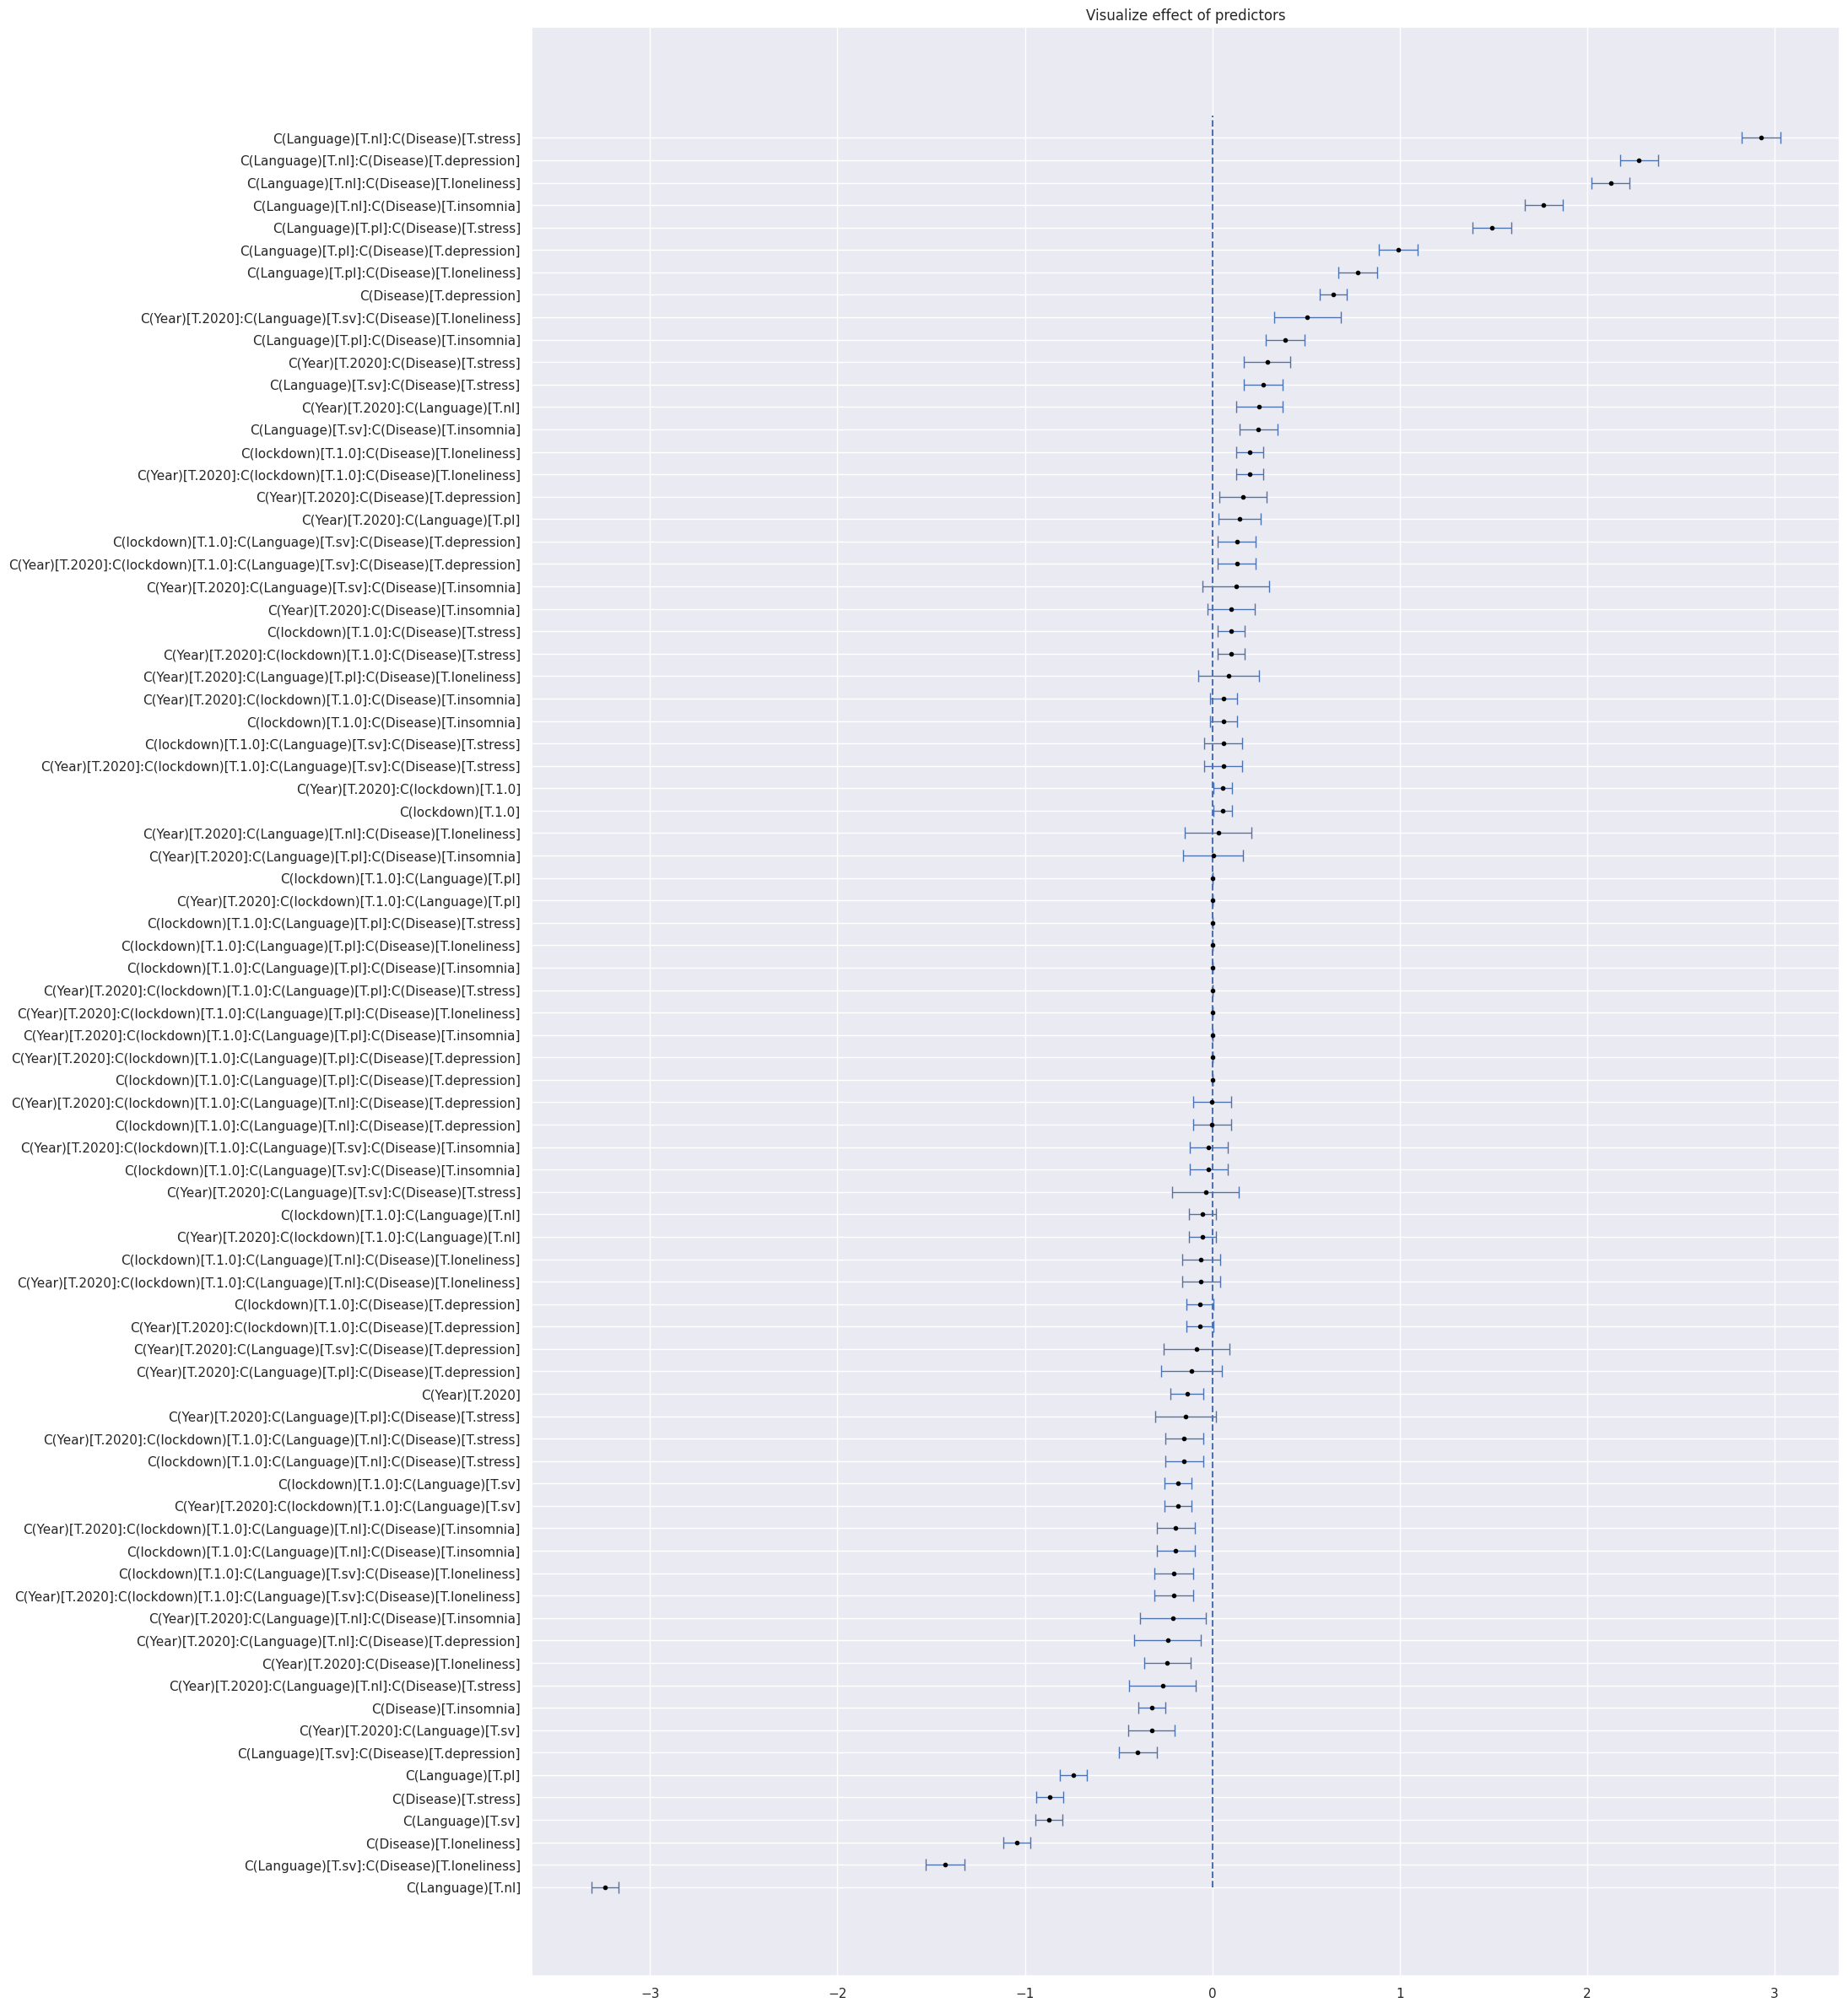

In [189]:
regression()